Part A: In this first example, I used a similar setup to the tutorial example. I changed the beam length to 10, used 6 node tri element shape, adjusted the number of elements in the beam, increased the load, and increased the number of steps. The error between the analytical solution and the computed solution in this example is 3.716940e-03, showing a very good result for the solver under these conditions. 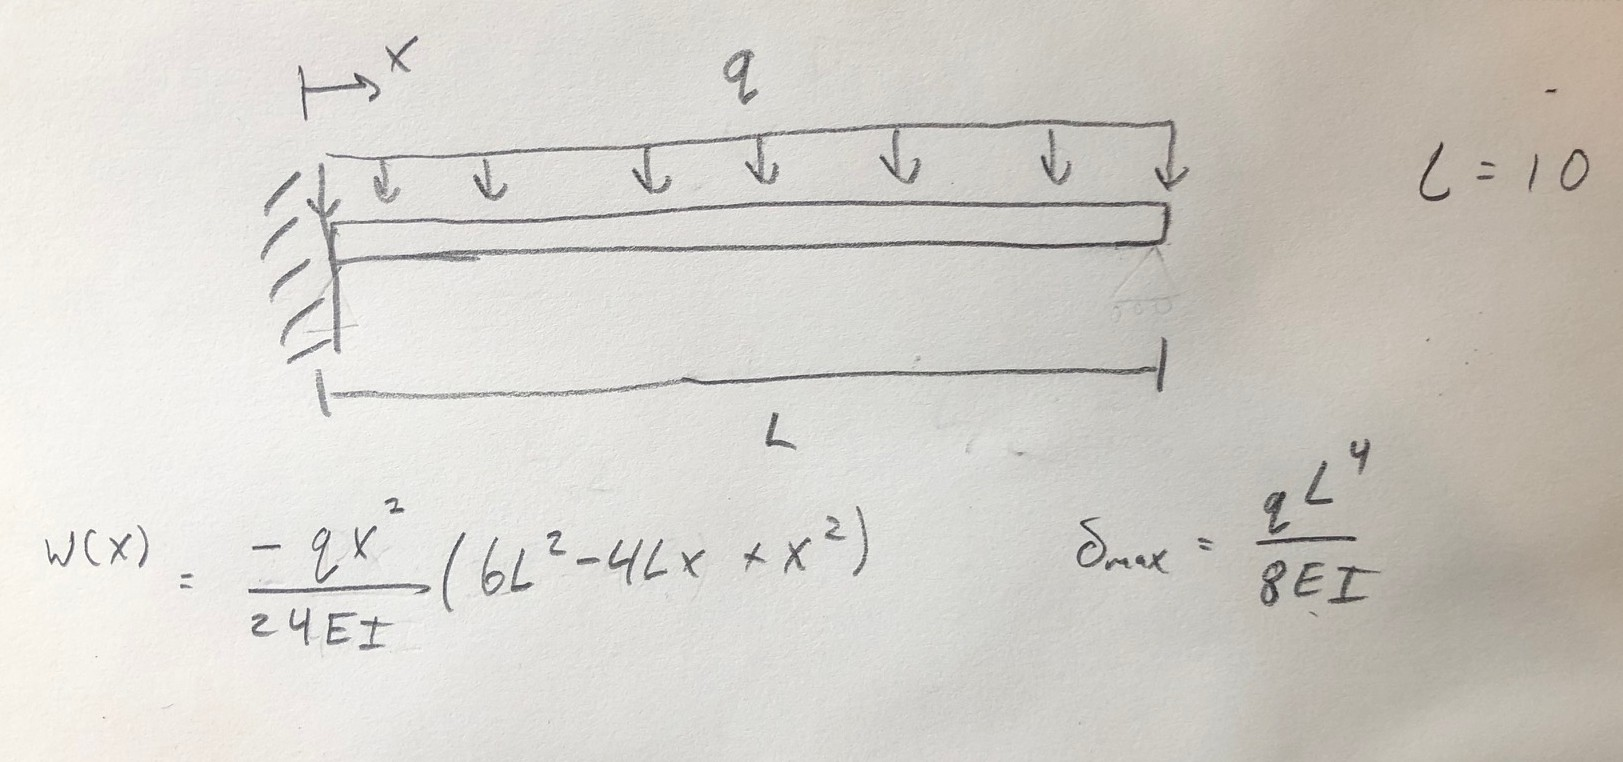

In [2]:
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

%matplotlib inline

# Set up a 2D cantilever beam under a uniform downward traction on the top edge.
# The left edge (x=0) is clamped. For small deflection, compare the tip displacement
# at x=L, y=H/2 with the Euler–Bernoulli beam formula:
# For a cantilever of length L, height H, uniform load q, plane strain,
#   Material:
#         E = 1000, nu = 0.3.
#     Derived:
#         mu    = E/(2*(1+nu))
#         kappa = E/(3*(1-2*nu))
    
#     Analytical tip deflection for a cantilever beam under uniform load q is:
#         w(L) = q*L^4 / (8*E*I),   I = H^3/12.


# --- Beam geometry ---
L = 10.0   # length in x
H = 1.0    # height in y
nx = 40    # number of elements along length
ny = 4     # number of elements along height

ele_type = "D2_nn6_tri"  # 2D, 6-node tri 
ndof = 2                  # 2 DOFs per node (x, y)


coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)


# --- Identify boundaries ---
boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
    coords, connect, ele_type, x_lower=0.0, x_upper=L, y_lower=0.0, y_upper=H
)

# 1) Clamp the left edge: fix x- and y-displacements = 0
fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)

# 2) Uniform downward traction on the top edge (y=H)
# Let q be negative in the y-direction
q = -0.01  # load per unit length in x
# For a 2D plane strain problem, this is a traction (tx, ty) = (0, q)
dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)

# Combine boundary conditions
fixed_nodes = fixed_left  # only the left edge is clamped

# --- Material properties ---
E = 1000.0
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))

material_props = np.array([mu, kappa])
print(f"Material properties: mu={mu:.3f}, kappa={kappa:.3f}")

# Number of incremental load steps
nr_num_steps = 5

# --- Solve with your hyperelastic solver ---
displacements_all, nr_info_all = hyperelastic_solver(
    material_props,
    ele_type,
    coords.T,      # shape (2, n_nodes)
    connect.T,     # shape (n_nodes_per_elem, n_elems)
    fixed_nodes,
    dload_info,
    nr_print=True,
    nr_num_steps=nr_num_steps,
    nr_tol=1e-10,
    nr_maxit=30,
)

final_disp = displacements_all[-1]  # shape: (n_nodes*ndof,)

# --- Compute the tip displacement from the FEA result ---
# We'll pick a node near x=L, y=H/2
tip_node = None
tol = 1e-3
for i, (x, y) in enumerate(coords):
    if abs(x - L) < tol and abs(y - H/2) < H/(2*ny):
        tip_node = i
        break
if tip_node is None:
    raise ValueError("Could not find tip node near x=L, y=H/2.")

tip_disp_y = final_disp[ndof*tip_node + 1]  # the y-component of displacement

# --- Compare with Euler–Bernoulli formula for small deflection ---
mu = material_props[0]
E_eff = E / (1 - nu ** 2.0)
I = H ** 3 / 12.0
w_analytical = q * L ** 4 / (8.0 * E_eff * I)

print(f"Tip node index: {tip_node}, coordinates={coords[tip_node]}")
print(f"Computed tip deflection (y): {tip_disp_y:.6f}")
print(f"Analytical Euler-Bernoulli deflection: {w_analytical:.6f}")

# --- Evaluate error ---
error = abs(tip_disp_y - w_analytical)
print(f"Absolute error = {error:.6e}")


# --- Plot the mesh with the final deformed shape ---
img_name = "full_code_example_2.gif"
viz.make_deformation_gif(displacements_all, coords, connect, ele_type, img_name)
from IPython.display import HTML, display

# Display animated GIF (correctly, looped)
display(HTML(f'<img src="{img_name}" width="600" loop>'))




Material properties: mu=384.615, kappa=833.333
Step 0, load factor = 0.200
Iteration 1, Correction=1.000000e+00, Residual=1.613580e-06, tolerance=1.000000e-10
Iteration 2, Correction=1.513276e-03, Residual=1.155399e-05, tolerance=1.000000e-10
Iteration 3, Correction=4.067850e-06, Residual=8.061526e-11, tolerance=1.000000e-10
Iteration 4, Correction=2.586165e-13, Residual=5.483277e-16, tolerance=1.000000e-10
Step 1, load factor = 0.400
Iteration 1, Correction=5.000997e-01, Residual=1.613580e-06, tolerance=1.000000e-10
Iteration 2, Correction=7.559970e-04, Residual=1.157505e-05, tolerance=1.000000e-10
Iteration 3, Correction=1.982232e-06, Residual=8.065701e-11, tolerance=1.000000e-10
Iteration 4, Correction=1.471940e-13, Residual=5.513121e-16, tolerance=1.000000e-10
Step 2, load factor = 0.600
Iteration 1, Correction=3.335073e-01, Residual=1.613580e-06, tolerance=1.000000e-10
Iteration 2, Correction=5.035797e-04, Residual=1.159555e-05, tolerance=1.000000e-10
Iteration 3, Correction=1.286

Part A: GIF Last frame image
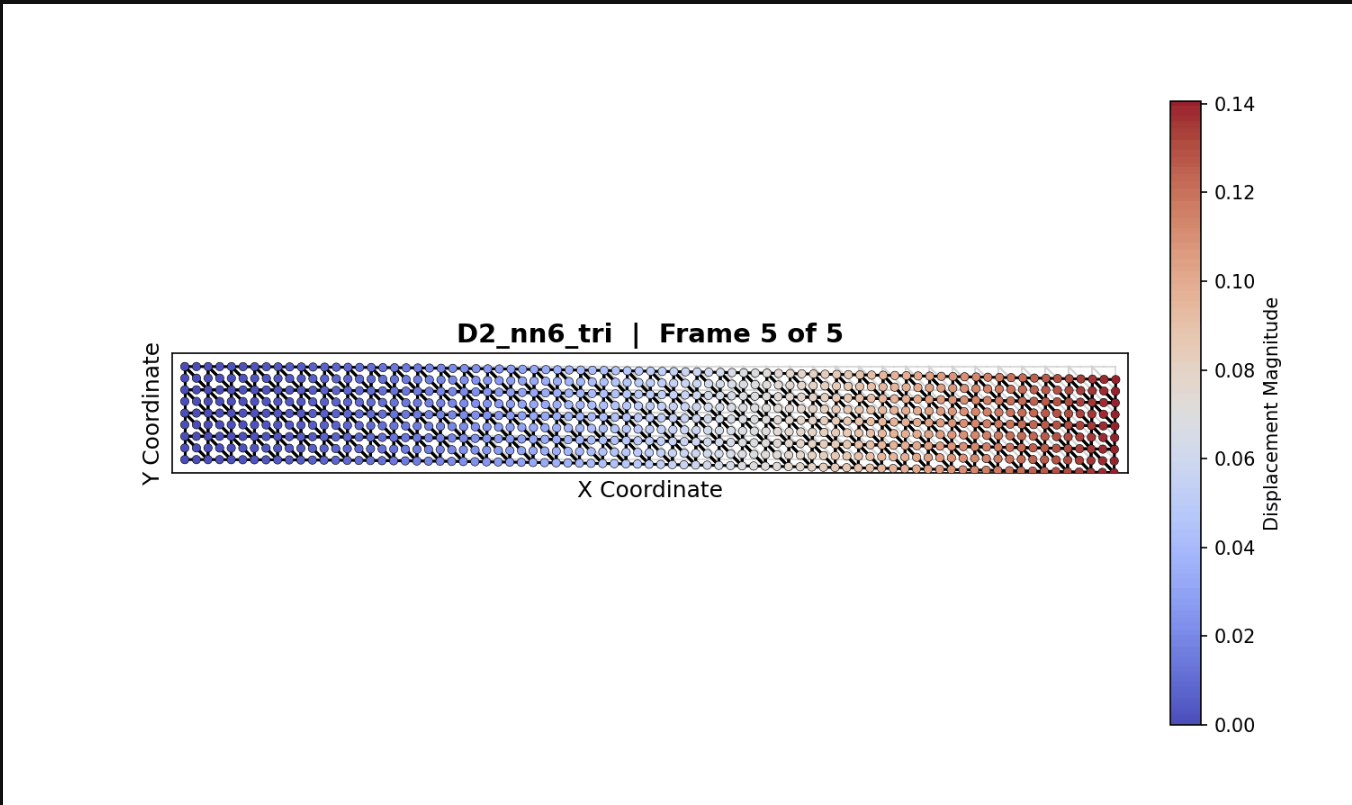

Part B: In this example, I have increased the uniform load across the bar from the above example to make this a large displacement. In this example we will examine the importance of mesh refinement. The graph below shows the tip displacement of the bar as the mesh grows finer for both linear elements and second order quadratic elements. One can see how much more quickly the higher order elements converge to a solution, while the linear elements struggle to do so. 

Step 0, load factor = 0.200
Iteration 1, Correction=1.000000e+00, Residual=2.083333e-02, tolerance=1.000000e-10
Iteration 2, Correction=5.190028e-03, Residual=4.490775e-02, tolerance=1.000000e-10
Iteration 3, Correction=1.068855e-06, Residual=4.054332e-06, tolerance=1.000000e-10
Iteration 4, Correction=1.193564e-12, Residual=1.371232e-13, tolerance=1.000000e-10
Step 1, load factor = 0.400
Iteration 1, Correction=4.998735e-01, Residual=2.083333e-02, tolerance=1.000000e-10
Iteration 2, Correction=2.606755e-03, Residual=4.491162e-02, tolerance=1.000000e-10
Iteration 3, Correction=6.302746e-07, Residual=4.056198e-06, tolerance=1.000000e-10
Iteration 4, Correction=5.292272e-13, Residual=1.330997e-13, tolerance=1.000000e-10
Step 2, load factor = 0.600
Iteration 1, Correction=3.330431e-01, Residual=2.083333e-02, tolerance=1.000000e-10
Iteration 2, Correction=1.747358e-03, Residual=4.487535e-02, tolerance=1.000000e-10
Iteration 3, Correction=1.093490e-06, Residual=4.059205e-06, tolerance=1.000

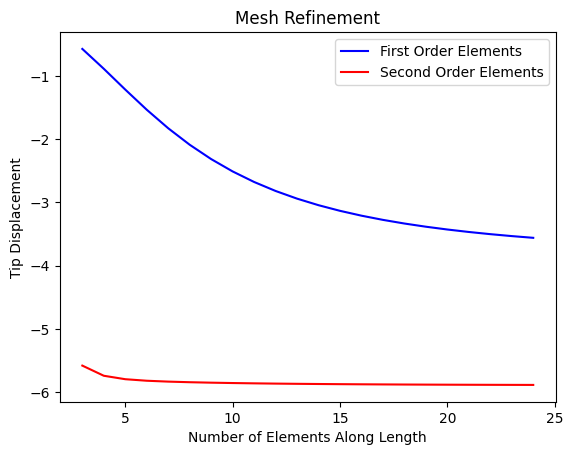

In [22]:
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

%matplotlib inline

# Set up a 2D cantilever beam under a uniform downward traction on the top edge.
# The left edge (x=0) is clamped. For small deflection, compare the tip displacement
# at x=L, y=H/2 with the Euler–Bernoulli beam formula:
# For a cantilever of length L, height H, uniform load q, plane strain,
#   Material:
#         E = 1000, nu = 0.3.
#     Derived:
#         mu    = E/(2*(1+nu))
#         kappa = E/(3*(1-2*nu))
    
#     Analytical tip deflection for a cantilever beam under uniform load q is:
#         w(L) = q*L^4 / (8*E*I),   I = H^3/12.




test_elem = ["D2_nn3_tri","D2_nn6_tri"]

displace_list_1 = []
displace_list_2 = []
mesh_list = []

for elem in test_elem:

    for j in range(3,25):

        # --- Beam geometry ---
        L = 10.0   # length in x
        H = 1.0    # height in y
        nx = j    # number of elements along length
        ny = 2    # number of elements along height
        ele_type = elem  
        ndof = 2                  # 2 DOFs per node (x, y)
        
        
        coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)
        
        
        # --- Identify boundaries ---
        boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
            coords, connect, ele_type, x_lower=0.0, x_upper=L, y_lower=0.0, y_upper=H
        )
        
        # 1) Clamp the left edge: fix x- and y-displacements = 0
        fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)
        
        # 2) Uniform downward traction on the top edge (y=H)
        # Let q be negative in the y-direction
        q = -.5  # load per unit length in x
        # For a 2D plane strain problem, this is a traction (tx, ty) = (0, q)
        dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)
        
        # Combine boundary conditions
        fixed_nodes = fixed_left  # only the left edge is clamped
        
        # --- Material properties ---
        E = 1000.0
        nu = 0.3
        mu = E / (2.0 * (1.0 + nu))
        kappa = E / (3.0 * (1.0 - 2.0 * nu))
        
        material_props = np.array([mu, kappa])
        #print(f"Material properties: mu={mu:.3f}, kappa={kappa:.3f}")
        
        # Number of incremental load steps
        nr_num_steps = 5
        
        # --- Solve with your hyperelastic solver ---
        displacements_all, nr_info_all = hyperelastic_solver(
            material_props,
            ele_type,
            coords.T,      # shape (2, n_nodes)
            connect.T,     # shape (n_nodes_per_elem, n_elems)
            fixed_nodes,
            dload_info,
            nr_print=True,
            nr_num_steps=nr_num_steps,
            nr_tol=1e-10,
            nr_maxit=30,
        )
        
        final_disp = displacements_all[-1]  # shape: (n_nodes*ndof,)
        
        # --- Compute the tip displacement from the FEA result ---
        # We'll pick a node near x=L, y=H/2
        tip_node = None
        tol = 1e-3
        for i, (x, y) in enumerate(coords):
            if abs(x - L) < tol and abs(y - H/2) < H/(2*ny):
                tip_node = i
                break
        if tip_node is None:
            raise ValueError("Could not find tip node near x=L, y=H/2.")
        
        tip_disp_y = final_disp[ndof*tip_node + 1]  # the y-component of displacement
    
        # --- Compare with Euler–Bernoulli formula for small deflection ---
        mu = material_props[0]
        E_eff = E / (1 - nu ** 2.0)
        I = H ** 3 / 12.0
        w_analytical = q * L ** 4 / (8.0 * E_eff * I)

        if elem == "D2_nn3_tri":
            displace_list_1.append(tip_disp_y)
            mesh_list.append(j)
        else:
            displace_list_2.append(tip_disp_y)

plt.plot(mesh_list, displace_list_1, label='First Order Elements', color='blue')  # Just a line
plt.plot(mesh_list, displace_list_2, label='Second Order Elements', color='red')   # Another line
plt.title("Mesh Refinement")                 # Title of the plot
plt.xlabel("Number of Elements Along Length")         # Label for x-axis
plt.ylabel("Tip Displacement")  
plt.legend(loc='upper right')

plt.savefig("Mesh Refinement", dpi=300)



Part C: In this last example, the uniform load across the beam was too great and led to the solver failing. The solver fails because the number of incremental load steps is too low for such a large load, which leads to an invalid determinant. This error can be solved by increasing the number of incremental steps the solver uses. Below this example, i have increased the number of steps to 5, which allows the solver to compute the displacement.

Material properties: mu=384.615, kappa=833.333
Step 0, load factor = 1.000
Iteration 1, Correction=1.000000e+00, Residual=1.237713e-02, tolerance=1.000000e-10
Iteration 2, Correction=4.337877e-01, Residual=2.673737e+02, tolerance=1.000000e-10
Iteration 3, Correction=0.000000e+00, Residual=nan, tolerance=1.000000e-10
Tip node index: 104, coordinates=[10.   0.5]
Computed tip deflection (y): nan
Analytical Euler-Bernoulli deflection: -27.300000
Absolute error = nan


C:\Users\tsand\Downloads\FINAL_Assignment-3-main (7)\Assignment-3-main\src\finiteelementanalysis\solver.py:133: MatrixRankWarning: Matrix is exactly singular
  d_displacement = spla.spsolve(K_sparse, R)


ValueError: Axis limits cannot be NaN or Inf

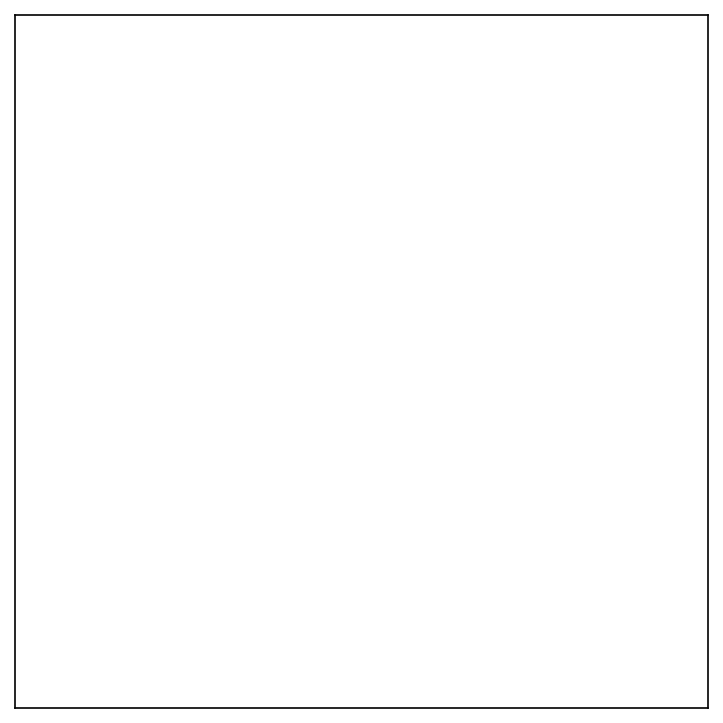

In [5]:
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

%matplotlib inline

# Set up a 2D cantilever beam under a uniform downward traction on the top edge.
# The left edge (x=0) is clamped. For small deflection, compare the tip displacement
# at x=L, y=H/2 with the Euler–Bernoulli beam formula:
# For a cantilever of length L, height H, uniform load q, plane strain,
#   Material:
#         E = 1000, nu = 0.3.
#     Derived:
#         mu    = E/(2*(1+nu))
#         kappa = E/(3*(1-2*nu))
    
#     Analytical tip deflection for a cantilever beam under uniform load q is:
#         w(L) = q*L^4 / (8*E*I),   I = H^3/12.


# --- Beam geometry ---
L = 10.0   # length in x
H = 1.0    # height in y
nx = 10    # number of elements along length
ny = 4     # number of elements along height

ele_type = "D2_nn6_tri"  # 2D, 6-node tri 
ndof = 2                  # 2 DOFs per node (x, y)


coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)


# --- Identify boundaries ---
boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
    coords, connect, ele_type, x_lower=0.0, x_upper=L, y_lower=0.0, y_upper=H
)

# 1) Clamp the left edge: fix x- and y-displacements = 0
fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)

# 2) Uniform downward traction on the top edge (y=H)
# Let q be negative in the y-direction
q = -2  # load per unit length in x
# For a 2D plane strain problem, this is a traction (tx, ty) = (0, q)
dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)

# Combine boundary conditions
fixed_nodes = fixed_left  # only the left edge is clamped

# --- Material properties ---
E = 1000.0
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))

material_props = np.array([mu, kappa])
print(f"Material properties: mu={mu:.3f}, kappa={kappa:.3f}")

# Number of incremental load steps
nr_num_steps = 1

# --- Solve with your hyperelastic solver ---
displacements_all, nr_info_all = hyperelastic_solver(
    material_props,
    ele_type,
    coords.T,      # shape (2, n_nodes)
    connect.T,     # shape (n_nodes_per_elem, n_elems)
    fixed_nodes,
    dload_info,
    nr_print=True,
    nr_num_steps=nr_num_steps,
    nr_tol=1e-10,
    nr_maxit=30,
)

final_disp = displacements_all[-1]  # shape: (n_nodes*ndof,)

# --- Compute the tip displacement from the FEA result ---
# We'll pick a node near x=L, y=H/2
tip_node = None
tol = 1e-3
for i, (x, y) in enumerate(coords):
    if abs(x - L) < tol and abs(y - H/2) < H/(2*ny):
        tip_node = i
        break
if tip_node is None:
    raise ValueError("Could not find tip node near x=L, y=H/2.")

tip_disp_y = final_disp[ndof*tip_node + 1]  # the y-component of displacement

# --- Compare with Euler–Bernoulli formula for small deflection ---
mu = material_props[0]
E_eff = E / (1 - nu ** 2.0)
I = H ** 3 / 12.0
w_analytical = q * L ** 4 / (8.0 * E_eff * I)

print(f"Tip node index: {tip_node}, coordinates={coords[tip_node]}")
print(f"Computed tip deflection (y): {tip_disp_y:.6f}")
print(f"Analytical Euler-Bernoulli deflection: {w_analytical:.6f}")

# --- Evaluate error ---
error = abs(tip_disp_y - w_analytical)
print(f"Absolute error = {error:.6e}")


# --- Plot the mesh with the final deformed shape ---
img_name = "full_code_example_2.gif"
viz.make_deformation_gif(displacements_all, coords, connect, ele_type, img_name)
from IPython.display import HTML, display

# Display animated GIF (correctly, looped)
display(HTML(f'<img src="{img_name}" width="600" loop>'))




Part C continued: I have now increased the number of incremental steps to 5 which fixes the previous error, though the computed and analytical results are still far from realistic given the geometric limitations of the problem. 

In [ ]:
from finiteelementanalysis import pre_process as pre
from finiteelementanalysis import pre_process_demo_helper_fcns as pre_demo
from finiteelementanalysis.solver import hyperelastic_solver
from finiteelementanalysis import visualize as viz
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

%matplotlib inline

# Set up a 2D cantilever beam under a uniform downward traction on the top edge.
# The left edge (x=0) is clamped. For small deflection, compare the tip displacement
# at x=L, y=H/2 with the Euler–Bernoulli beam formula:
# For a cantilever of length L, height H, uniform load q, plane strain,
#   Material:
#         E = 1000, nu = 0.3.
#     Derived:
#         mu    = E/(2*(1+nu))
#         kappa = E/(3*(1-2*nu))
    
#     Analytical tip deflection for a cantilever beam under uniform load q is:
#         w(L) = q*L^4 / (8*E*I),   I = H^3/12.


# --- Beam geometry ---
L = 10.0   # length in x
H = 1.0    # height in y
nx = 10    # number of elements along length
ny = 4     # number of elements along height

ele_type = "D2_nn6_tri"  # 2D, 6-node tri 
ndof = 2                  # 2 DOFs per node (x, y)


coords, connect = pre.generate_rect_mesh_2d(ele_type, 0.0, 0.0, L, H, nx, ny)


# --- Identify boundaries ---
boundary_nodes, boundary_edges = pre.identify_rect_boundaries(
    coords, connect, ele_type, x_lower=0.0, x_upper=L, y_lower=0.0, y_upper=H
)

# 1) Clamp the left edge: fix x- and y-displacements = 0
fixed_left = pre.assign_fixed_nodes_rect(boundary_nodes, "left", 0.0, 0.0)

# 2) Uniform downward traction on the top edge (y=H)
# Let q be negative in the y-direction
q = -1  # load per unit length in x
# For a 2D plane strain problem, this is a traction (tx, ty) = (0, q)
dload_info = pre.assign_uniform_load_rect(boundary_edges, "top", 0.0, q)

# Combine boundary conditions
fixed_nodes = fixed_left  # only the left edge is clamped

# --- Material properties ---
E = 1000.0
nu = 0.3
mu = E / (2.0 * (1.0 + nu))
kappa = E / (3.0 * (1.0 - 2.0 * nu))

material_props = np.array([mu, kappa])
print(f"Material properties: mu={mu:.3f}, kappa={kappa:.3f}")

# Number of incremental load steps
nr_num_steps = 5

# --- Solve with your hyperelastic solver ---
displacements_all, nr_info_all = hyperelastic_solver(
    material_props,
    ele_type,
    coords.T,      # shape (2, n_nodes)
    connect.T,     # shape (n_nodes_per_elem, n_elems)
    fixed_nodes,
    dload_info,
    nr_print=True,
    nr_num_steps=nr_num_steps,
    nr_tol=1e-10,
    nr_maxit=30,
)

final_disp = displacements_all[-1]  # shape: (n_nodes*ndof,)

# --- Compute the tip displacement from the FEA result ---
# We'll pick a node near x=L, y=H/2
tip_node = None
tol = 1e-3
for i, (x, y) in enumerate(coords):
    if abs(x - L) < tol and abs(y - H/2) < H/(2*ny):
        tip_node = i
        break
if tip_node is None:
    raise ValueError("Could not find tip node near x=L, y=H/2.")

tip_disp_y = final_disp[ndof*tip_node + 1]  # the y-component of displacement

# --- Compare with Euler–Bernoulli formula for small deflection ---
mu = material_props[0]
E_eff = E / (1 - nu ** 2.0)
I = H ** 3 / 12.0
w_analytical = q * L ** 4 / (8.0 * E_eff * I)

print(f"Tip node index: {tip_node}, coordinates={coords[tip_node]}")
print(f"Computed tip deflection (y): {tip_disp_y:.6f}")
print(f"Analytical Euler-Bernoulli deflection: {w_analytical:.6f}")

# --- Evaluate error ---
error = abs(tip_disp_y - w_analytical)
print(f"Absolute error = {error:.6e}")


# --- Plot the mesh with the final deformed shape ---
img_name = "full_code_example_2.gif"
viz.make_deformation_gif(displacements_all, coords, connect, ele_type, img_name)
from IPython.display import HTML, display

# Display animated GIF (correctly, looped)
display(HTML(f'<img src="{img_name}" width="600" loop>'))




Part C: Last image of deflection GIF for
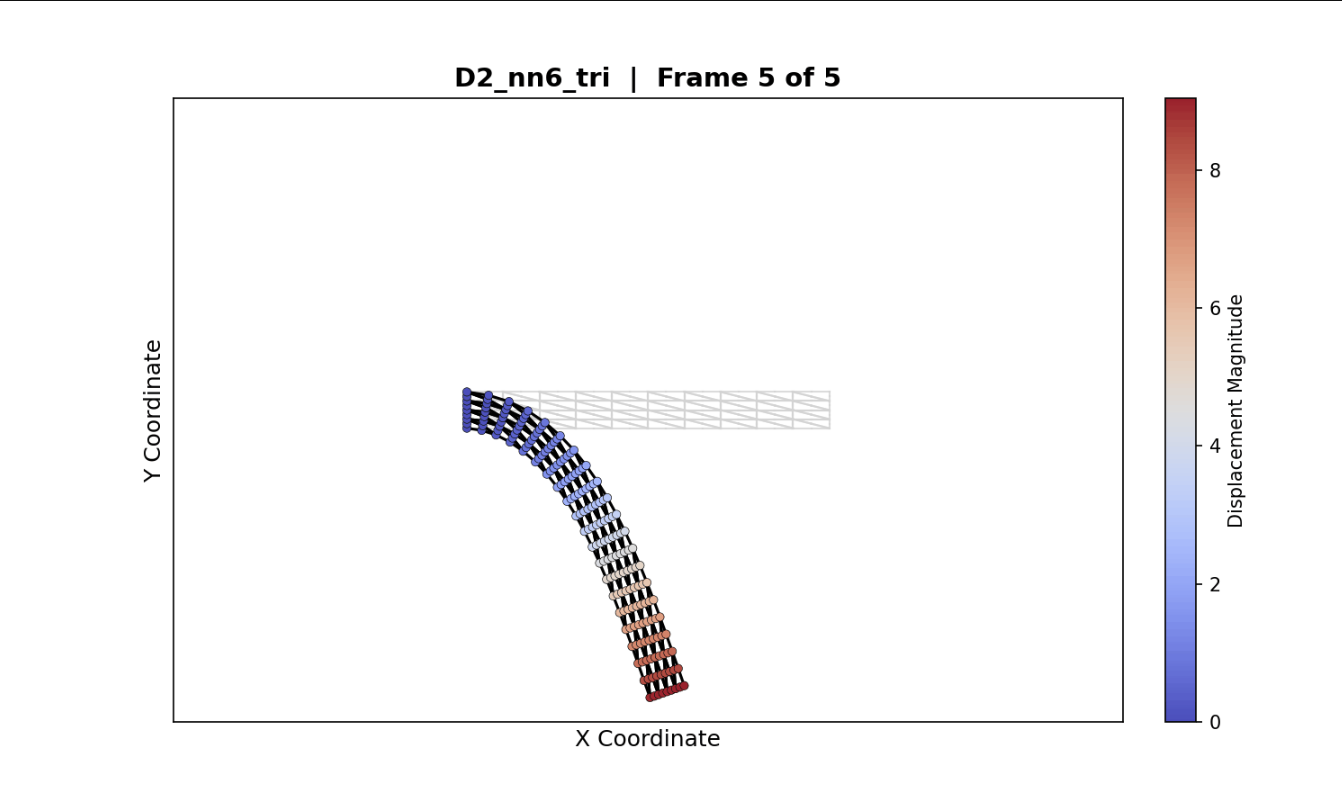